# LQR Controller Evaluation for Quadrotor

This notebook sets up a simple LQR controller on a 3D quadrotor using your existing environment and dynamics. It evaluates and plots the trajectory.

In [3]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from dynamics.quadrotor import QuadModel
from dynamics.QuadEnv import QuadEnv

# Define LQR controller
from scipy.linalg import solve_continuous_are

class LQRController:
    def __init__(self, A, B, Q=None, R=None):
        n = A.shape[0]
        m = B.shape[1]
        self.Q = np.eye(n) if Q is None else Q
        self.R = np.eye(m) if R is None else R
        P = solve_continuous_are(A, B, self.Q, self.R)
        self.K = np.linalg.inv(self.R) @ B.T @ P

    def get_control(self, x, x_target):
        return -self.K @ (x - x_target)


In [4]:
# Setup environment
env = QuadEnv()
state_dim = 6
action_dim = 3

# Define A, B around hover
A = np.zeros((6, 6))
A[:3, 3:] = np.eye(3)
B = np.zeros((6, 3))
B[3:, :] = np.eye(3)

# LQR weights
Q = np.diag([10, 10, 10, 1, 1, 1])
R = np.eye(3) * 0.1

# Create LQR controller
lqr = LQRController(A, B, Q, R)

# Define goal and reset
dt = env.dt
x_init = np.array([-1.5, 0, 0.4, 0, 0, 0])
x_goal = np.array([0.0, 0.0, 0.7, 0, 0, 0])
env.reset('det', reset_condition=(dt, x_init, x_goal))

states, actions = [], []

for t in range(env.n_time_rpod):
    obs = env.get_observation()
    x = obs['state']
    goal = obs['goal']
    u = lqr.get_control(x, goal)
    env.step(u)
    states.append(x)
    actions.append(u)

states = np.array(states)
actions = np.array(actions)


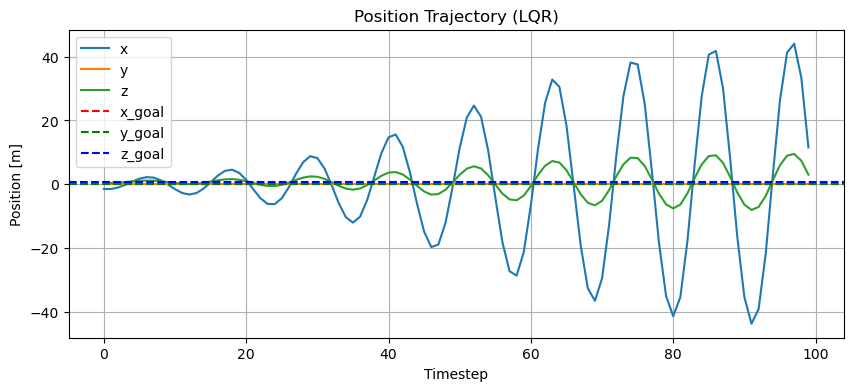

In [5]:
# Plot position trajectory
plt.figure(figsize=(10, 4))
plt.plot(states[:, 0], label='x')
plt.plot(states[:, 1], label='y')
plt.plot(states[:, 2], label='z')
plt.axhline(x_goal[0], color='r', linestyle='--', label='x_goal')
plt.axhline(x_goal[1], color='g', linestyle='--', label='y_goal')
plt.axhline(x_goal[2], color='b', linestyle='--', label='z_goal')
plt.title("Position Trajectory (LQR)")
plt.xlabel("Timestep")
plt.ylabel("Position [m]")
plt.legend()
plt.grid(True)
plt.show()
